## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

## And so on and so forth...

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from lanetracker.camera_calibrate import CameraCalibration
import glob
import cv2
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from lanetracker.color_thresh import hls_select
from lanetracker.color_thresh import rgb_select
from lanetracker.gradient_thresh import abs_sobel_thresh
from lanetracker.gradient_thresh import magnitude_thresh
from lanetracker.gradient_thresh import direction_threshold
from lanetracker.line import first_frame_lane_finder
from lanetracker.line import frame_lane_finder
from lanetracker.perspective import flatten_perspective

%matplotlib inline

In [3]:
images = glob.glob('../data/camera_cal/calibration*.jpg')
cal = CameraCalibration(images, retain_calibration_patterns=True)

Number of Success detected patterns:  17


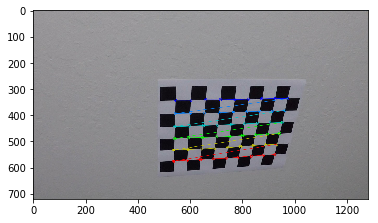

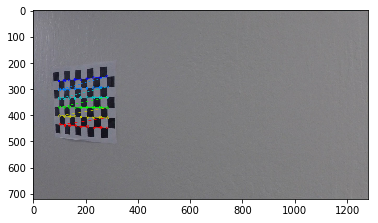

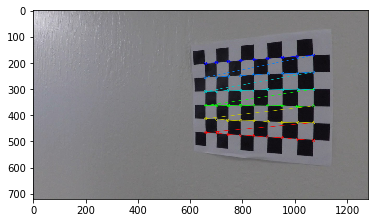

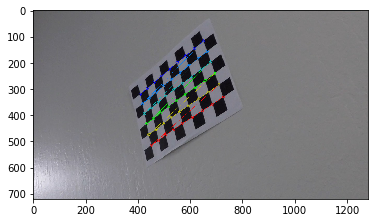

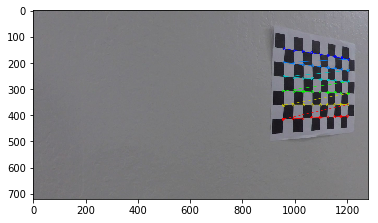

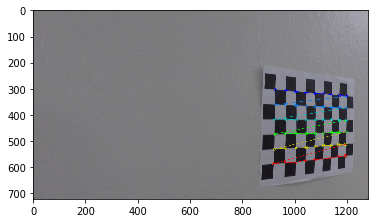

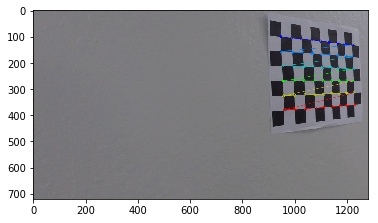

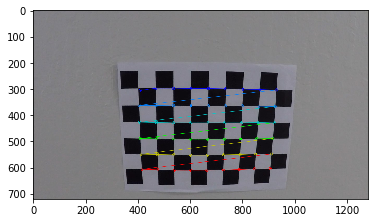

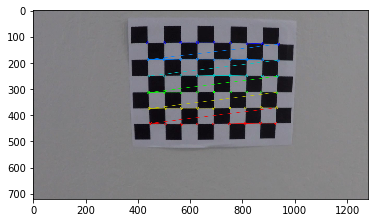

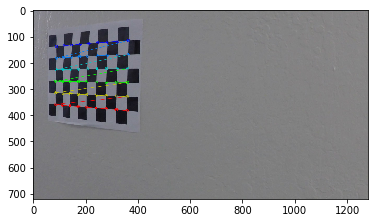

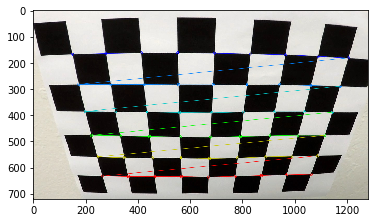

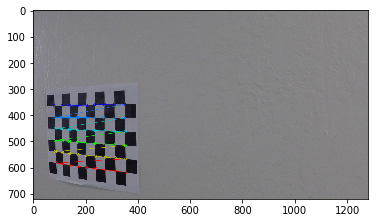

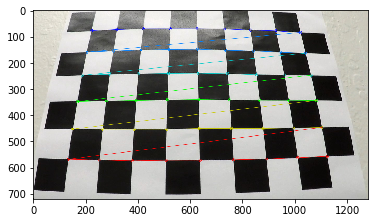

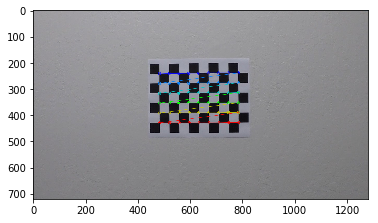

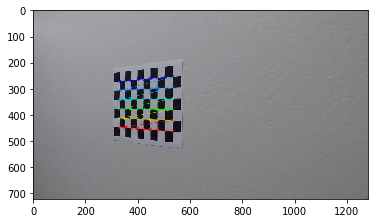

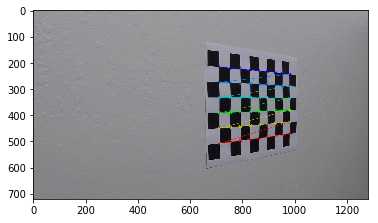

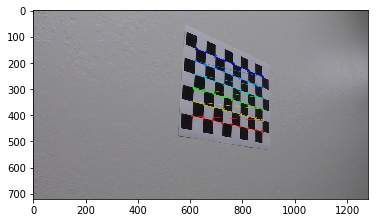

In [3]:
# Show the success patterns detected by cv2.findChessboardCorners

print("Number of Success detected patterns: ", len(cal.calibration_patterns_success))

for success_img in cal.calibration_patterns_success:
    plt.imshow(success_img)
    plt.show()

Number of Fail detected patterns:  3


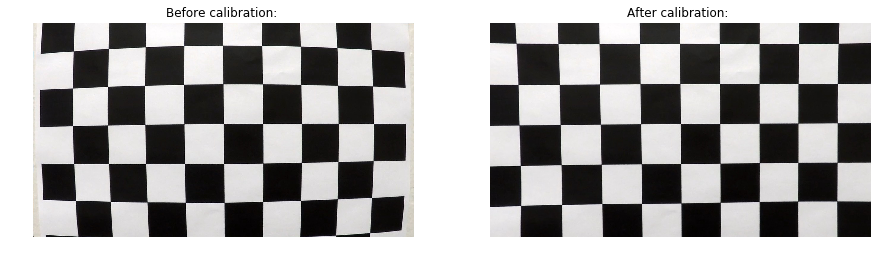

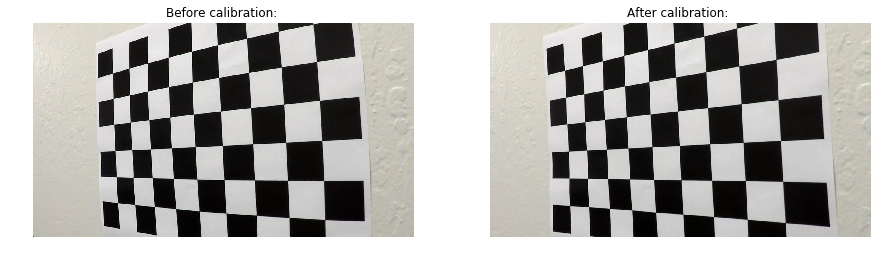

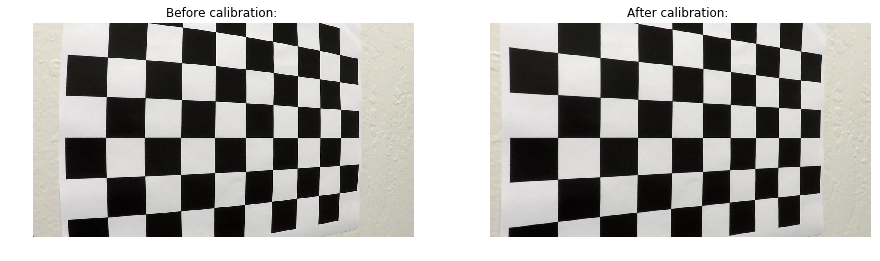

In [4]:
# Show the fail patterns which are not detected by cv2.findChessboardCorners
# And correct it with calibration method
print("Number of Fail detected patterns: ", len(cal.calibration_patterns_error))

for fail_img in cal.calibration_patterns_error:
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    axes[0].set_title("Before calibration: ")
    axes[0].set_axis_off()
    axes[1].set_title("After calibration: ")
    axes[1].set_axis_off()
    axes[0].imshow(fail_img)
    axes[1].imshow(cal(fail_img))


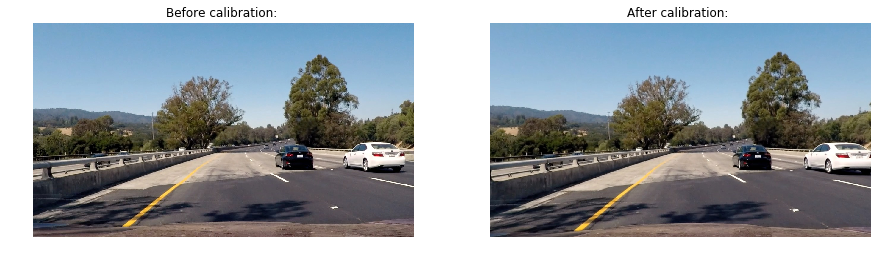

In [4]:
# Test CameraCalibration on car image

img = mpimg.imread('../test_images/test4.jpg')
# img = mpimg.imread('../test_images/straight_lines1.jpg')
# img = mpimg.imread('frame.jpeg')

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
axes[0].set_title("Before calibration: ")
axes[0].set_axis_off()
axes[0].imshow(img)

img_after_calibration = cal(img)

axes[1].set_title("After calibration: ")
axes[1].set_axis_off()
axes[1].imshow(img_after_calibration)

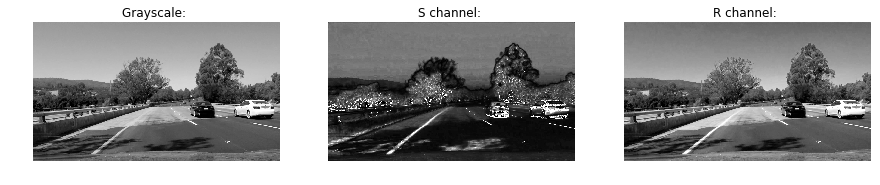

In [5]:
# grayscale vs s channel vs r channel: 
# We found that S channel could make white and yellow lane more contrastive to their background.
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
s_channel_img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)[:, :, 2]
r_channel_img = img[:, :, 0]

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
axes[0].set_title("Grayscale: ")
axes[0].set_axis_off()
axes[0].imshow(gray, cmap='gray')

axes[1].set_title("S channel: ")
axes[1].set_axis_off()
axes[1].imshow(s_channel_img, cmap='gray')

axes[2].set_title("R channel: ")
axes[2].set_axis_off()
axes[2].imshow(r_channel_img, cmap='gray')

In [6]:
# # Apply each of gredient thresholding functions

# gradx_binary = abs_sobel_thresh(s_channel_img, orient='x', sobel_kernel=3, thresh=(20, 100), debug=True)
# # mag_binary = magnitude_thresh(gray, sobel_kernel=9, thresh=(50, 100), debug=True)
# mag_binary = magnitude_thresh(s_channel_img, sobel_kernel=9, thresh=(50, 100), debug=True)
# # dir_binary = direction_threshold(gray, sobel_kernel=15, thresh=(0.7, 1.3), debug=True)
# dir_binary = direction_threshold(s_channel_img, sobel_kernel=15, thresh=(0.7, 1.3), debug=True)

# combined_binary = np.zeros_like(dir_binary)
# combined_binary[(gradx_binary == 1) | ((mag_binary == 1) & (dir_binary == 1))] = 1
# plt.imshow(combined_binary, cmap='gray');

In [7]:
# r_binary = rgb_select(img, channel='R', thresh=(220, 255), debug=True)
# # s_binary = hls_select(img, thresh=(70, 235), debug=False)
# # s_binary = hls_select(img, thresh=(70, 235), debug=True)
# # h_binary = hls_select(img, channel='h', thresh=(17, 70), debug=False)
# h_binary = hls_select(img, channel='h', thresh=(19, 70), debug=True)

# combined_binary = np.zeros_like(r_binary)
# combined_binary[(h_binary == 1) | (r_binary == 1)] = 1
# plt.imshow(combined_binary, cmap='gray');

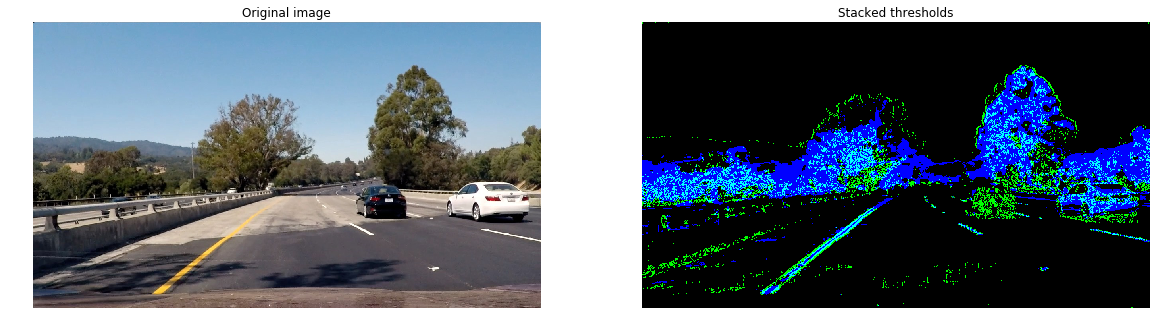

In [8]:
gradx_binary = abs_sobel_thresh(s_channel_img, orient='x', sobel_kernel=3, thresh=(20, 100), debug=False)
mag_binary = magnitude_thresh(s_channel_img, sobel_kernel=9, thresh=(50, 100), debug=False)
dir_binary = direction_threshold(s_channel_img, sobel_kernel=15, thresh=(0.7, 1.3), debug=False)
r_binary = rgb_select(img, channel='R', thresh=(220, 255), debug=False)
# s_binary = hls_select(img, thresh=(70, 235), debug=True)
h_binary = hls_select(img, channel='h', thresh=(19, 70), debug=False)

combined_binary = np.zeros_like(gradx_binary)
gredient_binary = np.zeros_like(gradx_binary)
color_binary = np.zeros_like(gradx_binary)
gredient_binary[(gradx_binary == 1) | ((mag_binary == 1) & (dir_binary == 1))] = 1
color_binary[(h_binary == 1) | (r_binary == 1)] = 1

# Stack each channel to view their individual contributions in green and blue respectively
# This returns a stack of the two binary images, whose components you can see as different colors.
#
# Green: gredient_binary
# Blue: color_binary
green_blue_binary = np.dstack((np.zeros_like(gredient_binary), gredient_binary, color_binary)) * 255

combined_binary[(gradx_binary == 1) | ((mag_binary == 1) & (dir_binary == 1)) | ((h_binary == 1) | (r_binary == 1))] = 1

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))

# ax1.set_title('Combined S channel and gradient thresholds')
# ax1.imshow(combined_binary, cmap='gray')
ax1.set_title('Original image')
ax1.set_axis_off()
ax1.imshow(img)


ax2.set_title('Stacked thresholds')
ax2.set_axis_off()
ax2.imshow(green_blue_binary)

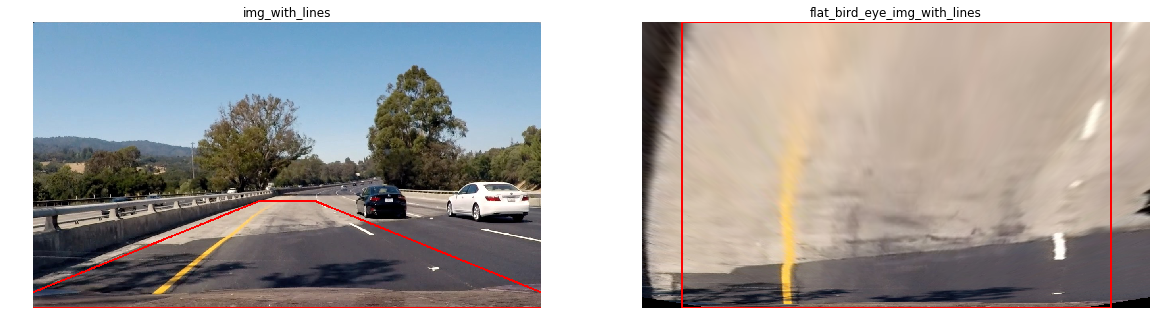

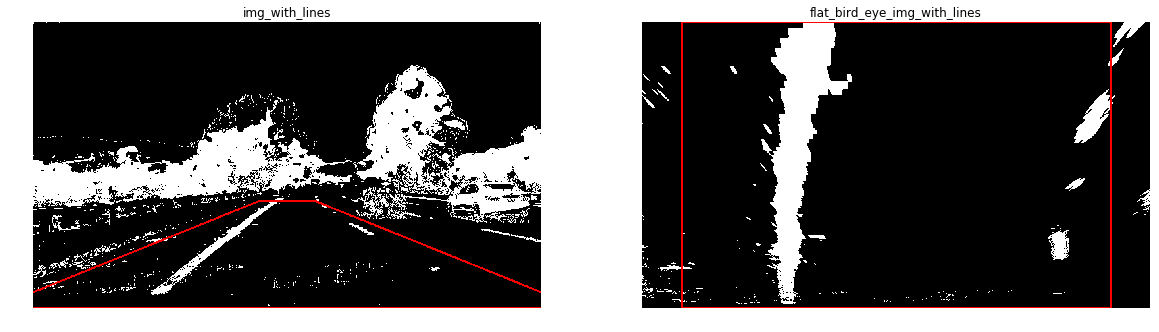

In [9]:
# bird_eye_binary, M = flatten_perspective(combined_binary, camera_offset=-30, half_of_lane_width=125, debug=True)
bird_eye_binary, M = flatten_perspective(img, top_offset=70, debug=True)
bird_eye_binary, M = flatten_perspective(combined_binary, top_offset=70, debug=True)

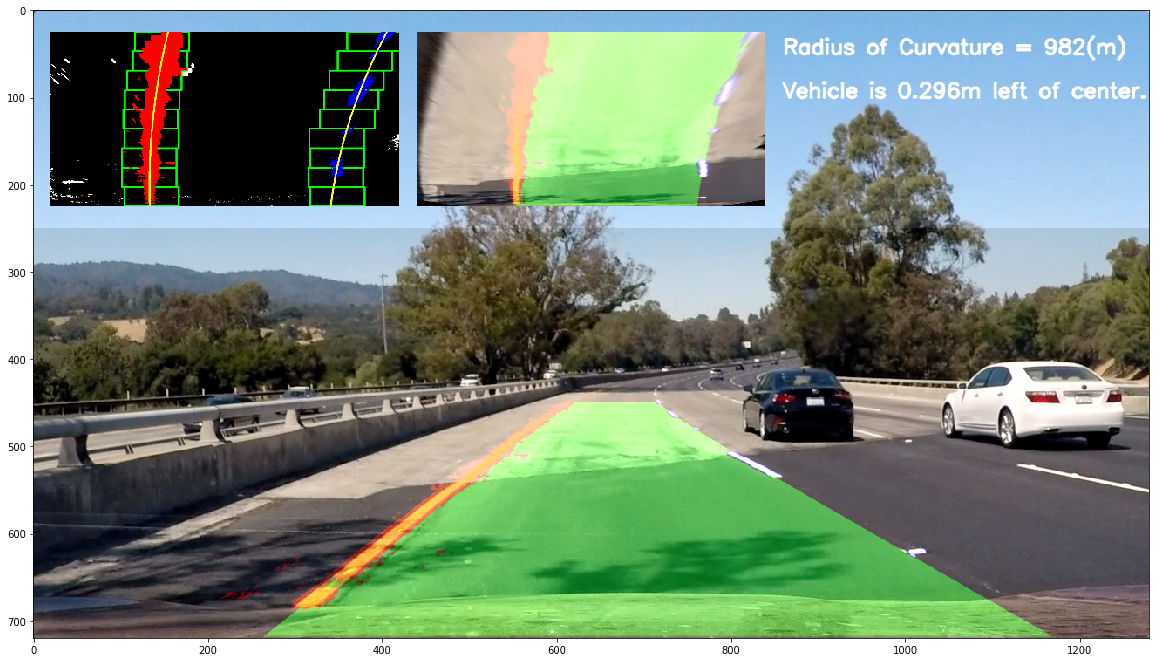

In [10]:
out_img, _, _ = first_frame_lane_finder(bird_eye_binary, M, img)
plt.figure(figsize=(20,20))
plt.imshow(out_img)

In [18]:
def static_var(varname, value):
    def decorate(func):
        setattr(func, varname, value)
        return func
    return decorate

@static_var("counter", 0)
@static_var("left_fit", None)
@static_var("right_fit", None)
def pipeline(img):
    pipeline.counter += 1
    img = cal(img)
    s_channel_img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)[:, :, 2]
    
    gradx_binary = abs_sobel_thresh(s_channel_img, orient='x', sobel_kernel=3, thresh=(20, 100), debug=False)
    mag_binary = magnitude_thresh(s_channel_img, sobel_kernel=9, thresh=(50, 100), debug=False)
    dir_binary = direction_threshold(s_channel_img, sobel_kernel=15, thresh=(0.7, 1.3), debug=False)
    r_binary = rgb_select(img, channel='R', thresh=(220, 255), debug=False)
    h_binary = hls_select(img, channel='h', thresh=(19, 70), debug=False)
    
    combined_binary = np.zeros_like(gradx_binary)
#     combined_binary[(gradx_binary == 1) | (((h_binary == 1) & (s_binary == 1)) | (r_binary == 1))] = 1
    combined_binary[(gradx_binary == 1) | ((mag_binary == 1) & (dir_binary == 1)) | ((h_binary == 1) | (r_binary == 1))] = 1
    out_img = np.dstack((combined_binary, combined_binary, combined_binary)) * 255
    
    
#     bird_eye_binary, M = flatten_perspective(combined_binary, camera_offset=-30, helf_of_lane_width=125 , debug=False)

    bird_eye_binary, M = flatten_perspective(combined_binary, top_offset=70, debug=False)
    if pipeline.counter == 1:
        out_img, pipeline.left_fit, pipeline.right_fit = first_frame_lane_finder(bird_eye_binary, M, img, debug=False)
    else:
        out_img, pipeline.left_fit, pipeline.right_fit = frame_lane_finder(bird_eye_binary, 
                                                pipeline.left_fit, pipeline.right_fit, M, img, debug=False)
    return out_img.astype(np.uint8)

In [25]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import *
from IPython.display import HTML

In [30]:
challenge_output = '../test_videos_output/challenge.gif'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip1 = VideoFileClip('../test_videos/challenge.mp4').subclip(0,5)
challenge_clip = clip1.fl_image(pipeline).resize(0.3)
challenge_clip.speedx(0.8).to_gif(challenge_output)
# %time challenge_clip.write_videofile(challenge_output, audio=False)


[MoviePy] Building file ../test_videos_output/challenge.gif with imageio



100%|██████████| 157/157 [00:54<00:00,  2.68it/s]


In [ ]:
challenge_output = '../test_videos_output/4K.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
# clip1 = VideoFileClip('../test_videos/4K.mp4').subclip(405,410)
clip1 = VideoFileClip('../test_videos/4K.mp4').subclip(80,85)
# clip1 = VideoFileClip('../test_videos/4K.mp4').subclip(25,27)
# clip1.save_frame("frame.jpeg", t=25)
challenge_clip = clip1.fl_image(pipeline)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [ ]:
# # Apply each of the thresholding functions
# gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(10, 100))
# grady = abs_sobel_thresh(img, orient='y', sobel_kernel=3, thresh=(10, 100))
# mag_binary = magnitude_thresh(img, sobel_kernel=9, thresh=(30, 100))
# dir_binary = direction_threshold(img, sobel_kernel=15, thresh=(0.7, 1.3))

# combined = np.zeros_like(dir_binary)
# combined[((gradx == 1) | (mag_binary == 1) & (dir_binary == 1))] = 1
# plt.imshow(combined, cmap='gray');

In [ ]:
# bird_eye_binary, M = flatten_perspective(combined_binary, debug=True)

In [ ]:
# r_binary = rgb_select(img, channel='R', thresh=(180, 255))
# # s_binary = hls_select(img, thresh=(90, 255), debug=True)
# gradx_binary = abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(10, 150))

# combined_binary = np.zeros_like(gradx_binary)
# combined_binary[(gradx_binary == 1) | (r_binary == 1)] = 1
# plt.imshow(combined_binary, cmap='gray')

In [ ]:
# bird_eye_binary, M = perspective_transform(combined_binary, debug=False)

In [ ]:
# out_img = bird_eye_view(bird_eye_binary, M, img, debug=True)

In [ ]:
# class line():
#     def __init__(self):
#         # was the line detected in the last iteration?
#         self.detected = False
#         # x values of the last n fits 

In [ ]:
# Warp the detected lane boundaries back onto the original image.
# Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.